<a href="https://colab.research.google.com/github/jieun-seong/MRC_redistricting/blob/main/py38_success_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user

--2022-06-14 14:52:20--  https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89817099 (86M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  85.66M  71.5MB/s    in 1.2s    

2022-06-14 14:52:21 (71.5 MB/s) - ‘mini.sh’ saved [89817099/89817099]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py38_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py38_0
    - cffi==1.14.0=py38h2e261b9_0
    - chardet==3.0.4=py38_1003
    - conda-package-handling==1.6.0=py38h7b6447c_0
    - conda==4.8.2=py38_0
    - cryptography==2.8

In [1]:
# Reload the web page and execute this cell
import sys
print("User Current Version:-", sys.version)

User Current Version:- 3.8.1 (default, Jan  8 2020, 22:29:32) 
[GCC 7.3.0]


In [2]:
!pip install gerrychain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 2.0 MB/s 
     |████████████████████████████████| 2.0 MB 6.6 MB/s 
     |████████████████████████████████| 1.0 MB 25.0 MB/s 
     |████████████████████████████████| 41.6 MB 1.2 MB/s 
     |████████████████████████████████| 11.3 MB 68.4 MB/s 
     |████████████████████████████████| 2.1 MB 63.1 MB/s 
     |████████████████████████████████| 7.7 MB 35.1 MB/s 
     |████████████████████████████████| 16.6 MB 25 kB/s 
     |████████████████████████████████| 1.2 MB 60.1 MB/s 
     |████████████████████████████████| 3.1 MB 55.4 MB/s 
     |████████████████████████████████| 930 kB 56.6 MB/s 
     |████████████████████████████████| 96 kB 7.6 MB/s 


In [3]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas, tqdm
import geopandas as gpd

# this makes the random assignment
from gerrychain.tree import recursive_tree_part

In [4]:
party_to_favor = "Democratic" #"Republican"
election_name = 'PRES16' 
bias_measure = 'safe_seats'
bias_measures = ['safe_seats', 'efficiency_gap', 'mean_median', 'partisan_bias', 'partisan_gini']

In [115]:
import numpy as np

def get_biased_accept(bias_measure):
    accept_dict = {
        'safe_seats' : increase_safe_seats,
        'efficiency_gap' : increase_efficiency_gap,
        'mean_median' : increase_mean_median,
        'partisan_bias' : increase_partisan_bias,
        'partisan_gini' : increase_partisan_gini
    }

    return accept_dict[bias_measure]

# this is from the Duchin, Needham, Weighill paper
def increase_safe_seats(partition):
    parent = partition.parent
    DEMseats = len(
        [x for x in partition[election_name].percents(party_to_favor) if x > 0.53]
    )
    DEMseatsparent = len(
        [x for x in parent[election_name].percents(party_to_favor) if x > 0.53]
    )
    alpha = np.exp(2*(DEMseats-DEMseatsparent))
    doaccept = (np.random.random() < alpha)
    return doaccept

def get_elec_results(x):
    # get ElectionResults for a map
    return x.updaters[election_name](x)

def increase_efficiency_gap(partition):
    parent = partition.parent

    curr = get_elec_results(partition)
    prev = get_elec_results(parent)

    ## change here if we are interested in different "bias" metric
    # https://gerrychain.readthedocs.io/en/latest/api.html#module-gerrychain.metrics
    delta = curr.efficiency_gap() - prev.efficiency_gap()
    beta = 300
        
    # accept immediately if "bias" is not decreasing
    # else: accept with some probability, Metropolis style
    return np.random.random() < np.exp(beta*delta)

def increase_mean_median(partition):
    parent = partition.parent

    curr = get_elec_results(partition)
    prev = get_elec_results(parent)

    delta = curr.mean_median() - prev.mean_median()
    beta = 300 # this should change with the bias metric
    
    # accept immediately if "bias" is not decreasing
    # else: accept with some probability, Metropolis style
    return np.random.random() < np.exp(beta*delta)

def increase_partisan_bias(partition):
    parent = partition.parent

    curr = get_elec_results(partition)
    prev = get_elec_results(parent)

    delta = curr.partisan_bias() - prev.partisan_bias()
    beta = 50 # this should change with the bias metric
        
    # accept immediately if "bias" is not decreasing
    # else: accept with some probability, Metropolis style
    return np.random.random() < np.exp(beta*delta)


def increase_partisan_gini(partition):
    parent = partition.parent

    curr = get_elec_results(partition)
    prev = get_elec_results(parent)

    delta = curr.partisan_gini() - prev.partisan_gini()
    beta = 300 # this should change with the bias metric
        
    # accept immediately if "bias" is not decreasing
    # else: accept with some probability, Metropolis style
    return np.random.random() < np.exp(beta*delta)


In [7]:
graph = Graph.from_json("NC.json")

In [12]:
elections = [
    # Election("SEN12", {"Democratic": "SEN12D", "Republican": "SEN12R"}),
    # Election("SEN16", {"Democratic": "EL16G_US_1", "Republican": "EL16G_USS_"}),
    # Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Democratic": "EL16G_PR_D", "Republican": "EL16G_PR_R"})
]

# Population updater, for computing how close to equality the district
# populations are. "TOTPOP" is the population column from our shapefile.
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}

# Election updaters, for computing election results using the vote totals
# from our shapefile.
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

initial_partition = GeographicPartition(graph, assignment="CD", updaters=my_updaters)

# find ideal population per district
ideal_pop = sum(initial_partition["population"].values()) / len(initial_partition)

# create a random assignment
random_assignment = recursive_tree_part(graph, 
                    # how many districts
                    parts = range(13),
                    # what is the population target
                   pop_target = ideal_pop,
                    # what column contains population infor
                    pop_col = "TOTPOP",
                    # allowed variation
                    epsilon = .01,
                    # still don't know what this is
                    node_repeats = 2
                   )

# create the random parititon by giving it the random assignment
random_partition = Partition(graph,
                              assignment = random_assignment,
                              updaters = my_updaters)
# The ReCom proposal needs to know the ideal population for the districts so that
# we can improve speed by bailing early on unbalanced partitions.

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [13]:
bias_chains = []
for bias in bias_measures:
    bias_chain = MarkovChain(proposal = proposal,
                            constraints = [pop_constraint, compactness_bound],
                            accept = get_biased_accept(bias),
                            initial_state = random_partition,
                            total_steps = 10000) 
    bias_chains.append(bias_chain)

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=random_partition,
    total_steps=10000
)



In [14]:
bias_ensembles = [[p for p in bc.with_progress_bar()][::10] for bc in bias_chains]

In [ ]:
# create a data frame where each column represents the node assignments
df = pandas.DataFrame.from_dict(bias_ensembles[0].assignment, orient='index', columns=["Step 0"])

for i in range(1,len(bias_ensembles)):
    df["Step "+ str(i)] = pandas.Series(bias_ensembles[i].assignment)
    
# add all 10 steps of the chain to the graph
graph.add_data(df)

# save it
graph.to_json("NC_bias.json")

In [75]:


for i in range(len(bias_measures)):
  graph_temp = Graph.from_json("NC.json")
  ens = bias_ensembles[i]
  df = pandas.DataFrame.from_dict(ens[0].assignment, orient='index', columns=["Step 0"])

  for j in range(1, len(ens)):
    df["Step "+ str(i)] = pandas.Series(ens[i].assignment)

  graph_temp.add_data(df)

  graph_temp.to_json("NC_bias_" + bias_measures[i] + ".json")

In [ ]:
df = pandas.DataFrame.from_dict(bias_ensembles[0].assignment, orient='index', columns=["Step 0"])

In [ ]:
for i in range(len(bias_ensembles)):
  for partition in bias_ensembles[i]:
    print((partition.assignment))

In [ ]:
from google.colab import files
files.download("NC_with_random_seed.json")
files.download("NC_bias.json")


In [23]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 5.2 MB/s 


Text(0.5, 1.0, 'NC_PRES16')

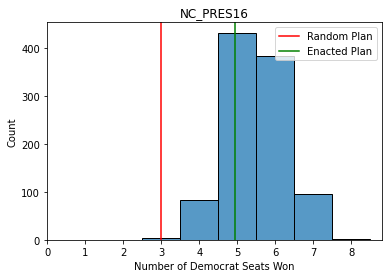

In [81]:
import numpy as np 
measure = 0
dem_seats = np.array([partition["PRES16"].seats("Democratic") for partition in bias_ensembles[measure]])
import seaborn as sns
# make a histogram of the number of seats won
sns.histplot(dem_seats, bins = max(dem_seats)+1, discrete = True)
plt.axvline(x=bias_ensembles[measure][0]["PRES16"].seats("Democratic"), color = "red", label = "Random Plan")
plt.axvline(x=initial_partition["PRES16"].seats("Democratic")-.05, color = "green", label = "Enacted Plan")
plt.legend(loc = "upper right")
plt.xticks(np.arange(0, max(dem_seats)+1, 1))
plt.xlabel("Number of Democrat Seats Won")
plt.title('NC_PRES16')

Text(0.5, 1.0, 'NC_PRES16')

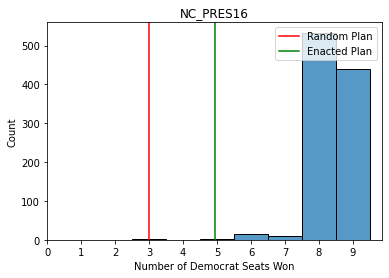

In [77]:
import numpy as np 
measure = 1
dem_seats = np.array([partition["PRES16"].seats("Democratic") for partition in bias_ensembles[measure]])
import seaborn as sns
# make a histogram of the number of seats won
sns.histplot(dem_seats, bins = max(dem_seats)+1, discrete = True)
plt.axvline(x=bias_ensembles[measure][0]["PRES16"].seats("Democratic"), color = "red", label = "Random Plan")
plt.axvline(x=initial_partition["PRES16"].seats("Democratic")-.05, color = "green", label = "Enacted Plan")
plt.legend(loc = "upper right")
plt.xticks(np.arange(0, max(dem_seats)+1, 1))
plt.xlabel("Number of Democrat Seats Won")
plt.title('NC_PRES16')

Text(0.5, 1.0, 'NC_PRES16')

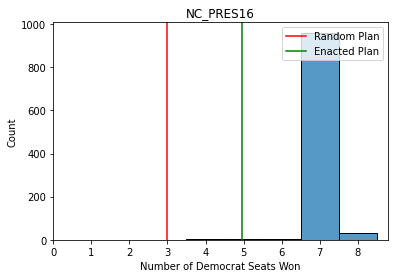

In [78]:
import numpy as np 
measure = 2
dem_seats = np.array([partition["PRES16"].seats("Democratic") for partition in bias_ensembles[measure]])
import seaborn as sns
# make a histogram of the number of seats won
sns.histplot(dem_seats, bins = max(dem_seats)+1, discrete = True)
plt.axvline(x=bias_ensembles[measure][0]["PRES16"].seats("Democratic"), color = "red", label = "Random Plan")
plt.axvline(x=initial_partition["PRES16"].seats("Democratic")-.05, color = "green", label = "Enacted Plan")
plt.legend(loc = "upper right")
plt.xticks(np.arange(0, max(dem_seats)+1, 1))
plt.xlabel("Number of Democrat Seats Won")
plt.title('NC_PRES16')

Text(0.5, 1.0, 'NC_PRES16')

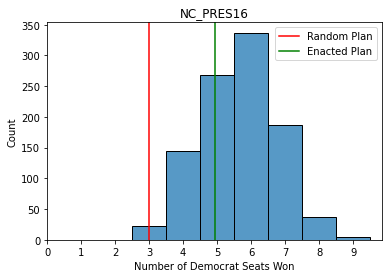

In [79]:
import numpy as np 
measure = 3
dem_seats = np.array([partition["PRES16"].seats("Democratic") for partition in bias_ensembles[measure]])
import seaborn as sns
# make a histogram of the number of seats won
sns.histplot(dem_seats, bins = max(dem_seats)+1, discrete = True)
plt.axvline(x=bias_ensembles[measure][0]["PRES16"].seats("Democratic"), color = "red", label = "Random Plan")
plt.axvline(x=initial_partition["PRES16"].seats("Democratic")-.05, color = "green", label = "Enacted Plan")
plt.legend(loc = "upper right")
plt.xticks(np.arange(0, max(dem_seats)+1, 1))
plt.xlabel("Number of Democrat Seats Won")
plt.title('NC_PRES16')

Text(0.5, 1.0, 'NC_PRES16')

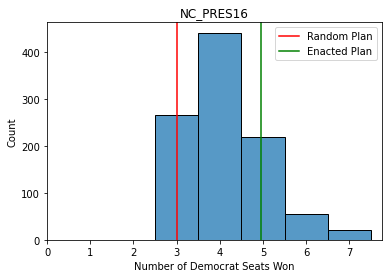

In [80]:
import numpy as np 
measure = 4
dem_seats = np.array([partition["PRES16"].seats("Democratic") for partition in bias_ensembles[measure]])
import seaborn as sns
# make a histogram of the number of seats won
sns.histplot(dem_seats, bins = max(dem_seats)+1, discrete = True)
plt.axvline(x=bias_ensembles[measure][0]["PRES16"].seats("Democratic"), color = "red", label = "Random Plan")
plt.axvline(x=initial_partition["PRES16"].seats("Democratic")-.05, color = "green", label = "Enacted Plan")
plt.legend(loc = "upper right")
plt.xticks(np.arange(0, max(dem_seats)+1, 1))
plt.xlabel("Number of Democrat Seats Won")
plt.title('NC_PRES16')

In [60]:
import json
data = []
# Opening JSON file
with open('NC_bias_efficiency_gap.json') as json_file:
    data = json.load(json_file)

Favor Republicans

In [116]:
party_to_favor = "Republican"
election_name = 'PRES16' 
bias_measure = 'safe_seats'
bias_measures = ['safe_seats', 'efficiency_gap', 'mean_median', 'partisan_bias', 'partisan_gini']

In [117]:
elections = [
    # Election("SEN12", {"Democratic": "SEN12D", "Republican": "SEN12R"}),
    # Election("SEN16", {"Democratic": "EL16G_US_1", "Republican": "EL16G_USS_"}),
    # Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Republican": "EL16G_PR_R", "Democratic": "EL16G_PR_D"})
]

# Population updater, for computing how close to equality the district
# populations are. "TOTPOP" is the population column from our shapefile.
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}

# Election updaters, for computing election results using the vote totals
# from our shapefile.
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

initial_partition = GeographicPartition(graph, assignment="CD", updaters=my_updaters)

# find ideal population per district
ideal_pop = sum(initial_partition["population"].values()) / len(initial_partition)

# create a random assignment
random_assignment = recursive_tree_part(graph, 
                    # how many districts
                    parts = range(13),
                    # what is the population target
                   pop_target = ideal_pop,
                    # what column contains population infor
                    pop_col = "TOTPOP",
                    # allowed variation
                    epsilon = .01,
                    # still don't know what this is
                    node_repeats = 2
                   )

# create the random parititon by giving it the random assignment
random_partition = Partition(graph,
                              assignment = random_assignment,
                              updaters = my_updaters)
# The ReCom proposal needs to know the ideal population for the districts so that
# we can improve speed by bailing early on unbalanced partitions.

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [118]:
bias_chains = []
for bias in bias_measures:
    bias_chain = MarkovChain(proposal = proposal,
                            constraints = [pop_constraint, compactness_bound],
                            accept = get_biased_accept(bias),
                            initial_state = random_partition,
                            total_steps = 10000) 
    bias_chains.append(bias_chain)

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=random_partition,
    total_steps=10000
)



In [95]:
bias_ensembles_rep = [[p for p in bc.with_progress_bar()][::10] for bc in bias_chains]

In [119]:
# just run for safe seats
bias_rep_safe_seats = [p for p in bias_chains[0].with_progress_bar()][::10]

In [124]:
# just run for mean median
bias_rep_mean_median = [p for p in bias_chains[2].with_progress_bar()][::10]

In [99]:


for i in range(len(bias_measures)):
  graph_temp = Graph.from_json("NC.json")
  ens = bias_ensembles_rep[i]
  df = pandas.DataFrame.from_dict(ens[0].assignment, orient='index', columns=["Step 0"])

  for j in range(1, len(ens)):
    df["Step "+ str(i)] = pandas.Series(ens[i].assignment)

  graph_temp.add_data(df)

  graph_temp.to_json("NC_bias_rep_" + bias_measures[i] + ".json")

Text(0.5, 1.0, 'NC_PRES16')

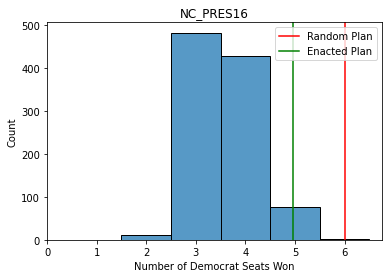

In [97]:
import numpy as np 
measure = 3
dem_seats = np.array([partition["PRES16"].seats("Democratic") for partition in bias_ensembles_rep[measure]])
import seaborn as sns
# make a histogram of the number of seats won
sns.histplot(dem_seats, bins = max(dem_seats)+1, discrete = True)
plt.axvline(x=bias_ensembles_rep[measure][0]["PRES16"].seats("Democratic"), color = "red", label = "Random Plan")
plt.axvline(x=initial_partition["PRES16"].seats("Democratic")-.05, color = "green", label = "Enacted Plan")
plt.legend(loc = "upper right")
plt.xticks(np.arange(0, max(dem_seats)+1, 1))
plt.xlabel("Number of Democrat Seats Won")
plt.title('NC_PRES16')

In [100]:
unbiased_chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=random_partition,
    total_steps=10000
)

In [102]:
unbiased_ensemble = [p for p in unbiased_chain.with_progress_bar()][::10]

In [105]:
graph_temp = Graph.from_json("NC.json")
# create a data frame where each column represents the node assignments
df = pandas.DataFrame.from_dict(unbiased_ensemble[0].assignment, orient='index', columns=["Step 0"])

for i in range(1,len(unbiased_ensemble)):
    df["Step "+ str(i)] = pandas.Series(unbiased_ensemble[i].assignment)
    
# add all 10 steps of the chain to the graph
graph_temp.add_data(df)

# save it
graph_temp.to_json("NC_unbiased_10_step_chain.json")

In [107]:
print("something")

something


In [125]:
dem_house_bias_ensembles = bias_ensembles
rep_house_bias_ensembles = bias_ensembles_rep
rep_house_bias_ensembles[0] = bias_rep_safe_seats
rep_house_bias_ensembles[2] = bias_rep_mean_median

# this cell calculates the various stats
# need your bias ensembles saved in a list called dem_house_bias_ensembles, rep_house_bias_ensembles
# need unbiased ensemble saved as unbiased_ensemble 

# a list of arrays, where each array is the distribution of seats that the dems won under a particular bias
dem_house_bias_ensembles_ss = [np.array([ len([x for x in p[election_name].percents("Democratic") if x >=.53])/len(p) for p in e]) for e in dem_house_bias_ensembles]
rep_house_bias_ensembles_ss = [np.array([ len([x for x in p[election_name].percents("Democratic") if x >=.53])/len(p) for p in e]) for e in rep_house_bias_ensembles]   

# just one array for the unbiased ensemble
unbiased_ensemble_ss = np.array([ len([x for x in p[election_name].percents("Democratic") if x >=.53])/len(p) for p in unbiased_ensemble])

# a list of arrays, where each array is the distribution of seats that the dems won under a particular bias
dem_house_bias_ensembles_sw = [np.array([p[election_name].seats("Democratic")/len(p) for p in e]) for e in dem_house_bias_ensembles]
rep_house_bias_ensembles_sw = [np.array([p[election_name].seats("Democratic")/len(p) for p in e]) for e in rep_house_bias_ensembles]   

# just one array for the unbiased ensemble
unbiased_ensemble_sw = np.array([p[election_name].seats("Democratic")/len(p) for p in unbiased_ensemble])

# a list of arrays, where each array is the distribution of partisan gini under a particular bias
dem_house_bias_ensembles_pg = [np.array([p[election_name].partisan_gini() for p in e]) for e in dem_house_bias_ensembles]
rep_house_bias_ensembles_pg = [np.array([p[election_name].partisan_gini() for p in e]) for e in rep_house_bias_ensembles]
   
# just one array for the unbiased ensemble
unbiased_ensemble_pg = np.array([p[election_name].partisan_gini() for p in unbiased_ensemble])

# a list of arrays, where each array is the distribution of partisan bias under a particular bias
dem_house_bias_ensembles_pb = [np.array([p[election_name].partisan_bias() for p in e]) for e in dem_house_bias_ensembles]
rep_house_bias_ensembles_pb = [np.array([p[election_name].partisan_bias() for p in e]) for e in rep_house_bias_ensembles]
   
# just one array for the unbiased ensemble
unbiased_ensemble_pb = np.array([p[election_name].partisan_bias() for p in unbiased_ensemble])

# a list of arrays, where each array is the distribution of mean median under a particular bias
dem_house_bias_ensembles_mm = [np.array([p[election_name].mean_median() for p in e]) for e in dem_house_bias_ensembles]
rep_house_bias_ensembles_mm = [np.array([p[election_name].mean_median() for p in e]) for e in rep_house_bias_ensembles]
   
# just one array for the unbiased ensemble
unbiased_ensemble_mm = np.array([p[election_name].mean_median() for p in unbiased_ensemble])

# a list of arrays, where each array is the distribution of efficiency gap under a particular bias
dem_house_bias_ensembles_eg = [np.array([p[election_name].efficiency_gap() for p in e]) for e in dem_house_bias_ensembles]
rep_house_bias_ensembles_eg = [np.array([p[election_name].efficiency_gap() for p in e]) for e in rep_house_bias_ensembles]
   
# just one array for the unbiased ensemble
unbiased_ensemble_eg = np.array([p[election_name].efficiency_gap() for p in unbiased_ensemble])


In [126]:
ss = (dem_house_bias_ensembles_ss, rep_house_bias_ensembles_ss)
sw = (dem_house_bias_ensembles_sw, rep_house_bias_ensembles_sw)
eg = (dem_house_bias_ensembles_eg, rep_house_bias_ensembles_eg)
pb = (dem_house_bias_ensembles_pb, rep_house_bias_ensembles_pb)
pg = (dem_house_bias_ensembles_pg, rep_house_bias_ensembles_pg)
mm = (dem_house_bias_ensembles_mm, rep_house_bias_ensembles_mm)

my_stats = [ss, eg, mm, pb, pg, sw]
unbias_stats = [unbiased_ensemble_ss, unbiased_ensemble_eg, unbiased_ensemble_mm, unbiased_ensemble_pb, unbiased_ensemble_pg, unbiased_ensemble_sw]


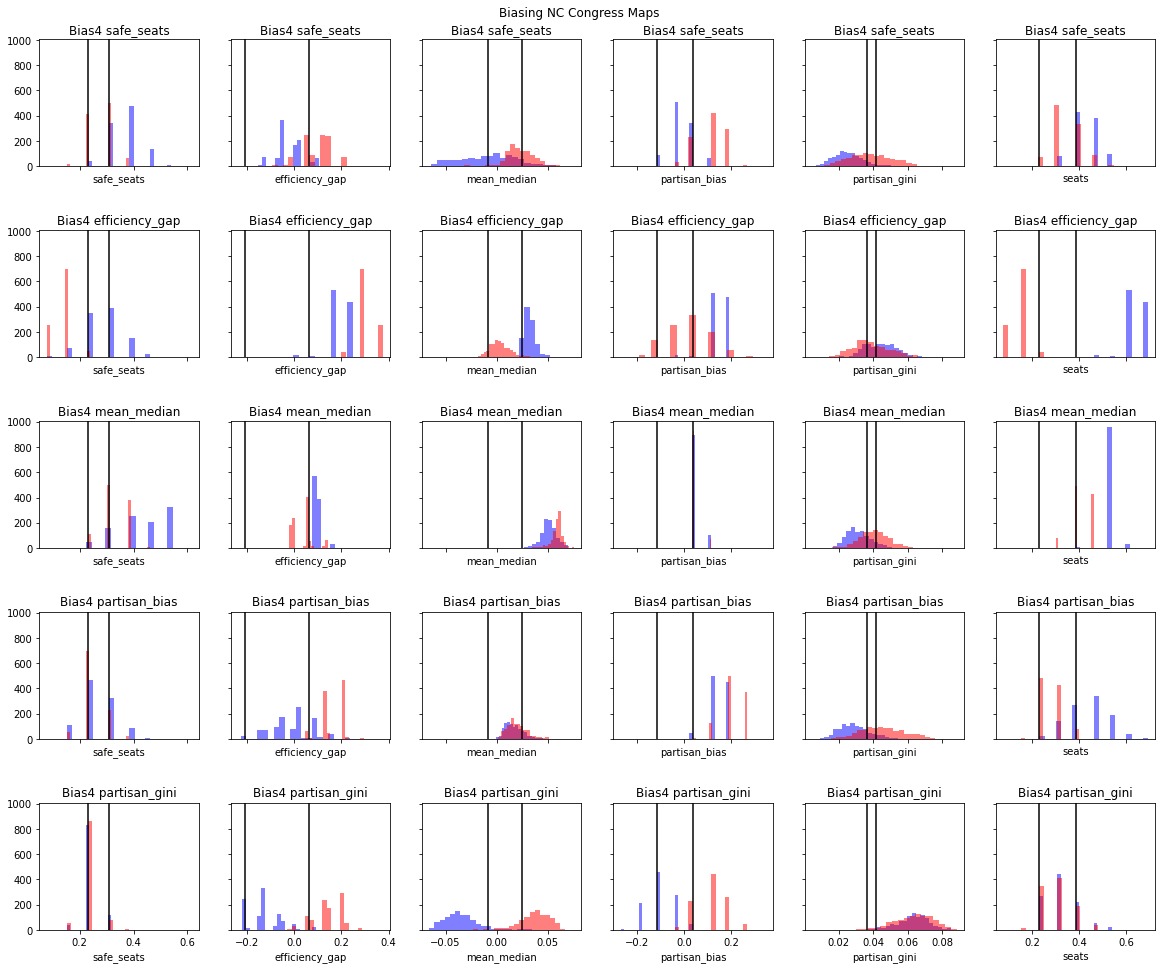

In [130]:
title = "./NC_CD.svg"# name of the file you want to save, I always use .svg as the extension
state = "NC"

# what to plot
dem, rep, unbias = True, True, False

# whether or not to save the file
save = False

bias_measures = ['safe_seats', 'efficiency_gap', 'mean_median',
                 'partisan_bias', 'partisan_gini', 'seats'] 

# we have 5 bias ensembles and 6 measures
n_row = 5
n_col = 6

num_bins = 20
fig, ax = plt.subplots(n_row, n_col, figsize=(20,15), sharey=True, sharex='col' )

# are you biasing the house??? the senate??? congress?
fig.suptitle("Biasing " +state + " Congress Maps")
# fix the vertical spacing
fig.subplots_adjust(hspace=.5)
# fix the title
fig.subplots_adjust(top=0.95)

counter = 0
for i, stat in enumerate(my_stats):
    for j, party in enumerate(stat):
        for k in range(len(party)):
            # overlay the three ensembles
            if j==0 and dem:
                ax[k,i].hist(party[k], bins = num_bins, label = "DBias", alpha = 0.5, color ="blue")
                

            if j==1 and rep:
                ax[k,i].hist(party[k], bins = num_bins, label = "RBias", alpha = 0.5, color = "red")
            
            if unbias:
                ax[k,i].hist(unbias_stats[i], bins = num_bins, label = "Unbiased", alpha = 0.5, color = "green")
            

            # seed plan
            ax[k,i].axvline(x=party[0][0], color = "black", label = "Seed Plan")
            ax[k,i].set_title("Bias4 " +bias_measures[k])
            ax[k,i].set_xlabel(bias_measures[i])
            

if save:
    plt.savefig(title)
plt.show()

In [129]:
print(title)

./file_name.svg
